## Trying to plot the mode intensity of the material
---

### Using QCL material
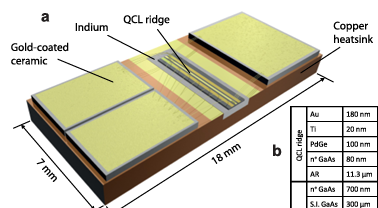
- The code represents the same material structure of the figure.  
- The height is in the y axis, the length is in the x axis.  
- Grating structure is also recorded in this part of the code.  

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from meep.materials import GaAs
import math

###-------------------------Material config--------------------------------------###
def drude_medium(N_cm3, tau_ps, m_eff_ratio, eps_inf)-> mp.Medium:
    # Constants
    e       = 1.602e-19
    eps0    = 8.854e-12
    m_e     = 9.109e-31
    m_eff   = m_eff_ratio * m_e
    c       = 299_792_458.0 * 1e6  # Speed of light in um/s
    N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    omega_p = math.sqrt(N_m3 * e * e / (eps0 * m_eff))  # [rad/s]
    gamma_s = 1.0 / (tau_ps * 1e-12)                     # [1/s]
    omega_meep    = omega_p / (2 * math.pi * c)           # Meep units [1/µm]
    gamma_meep   = gamma_s / (2 * math.pi * c)           # Meep units [1/µm]

    # # Convert units
    # N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    # tau     = tau_ps * 1e-12  # from ps to s

    # # Plasma frequency: ω_p^2 = Ne^2 / (eps0 * m*)
    # omega_p2_SI = N_m3 * e ** 2 / (eps0 * m_eff)  # in rad^2/s^2
    # gamma_SI    = 1 / tau  # in Hz

    # # Convert to Meep units (divide by unit_freq)
    # omega_p2_meep   = omega_p2_SI / (unit_freq ** 2)
    # gamma_meep      = gamma_SI / unit_freq

    # Return Meep medium object
    return mp.Medium(epsilon=eps_inf,E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_meep, 
                                                                gamma=gamma_meep, 
                                   )])

Au_fun          = drude_medium(N_cm3=5.6e22, tau_ps=0.05,    m_eff_ratio=0.067, eps_inf=1.0 )
GaAs_5e18_fun   = drude_medium(N_cm3=5.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_5e15_fun   = drude_medium(N_cm3=5.0e15, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_3e18_fun   = drude_medium(N_cm3=3.0e18, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_1e18_fun   = drude_medium(N_cm3=1.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_0_fun      = drude_medium(N_cm3=0, tau_ps=1.0,  m_eff_ratio=0.067, eps_inf=12.9)


###----------------------------------basic config----------------------------------###
dpml = 1  # PML thickness
resolution                  = 50
# thickness of different layers（1 μm）
Au_thickness                = 0.2
nGaAs_thickness_1           = 0.08
Active_region_thickness     = 11.3
nGaAs_thickness_2           = 0.7
substrate_GaAs_thickness    = 30
# Set up for source frequency 
c_um_s                      = 299_792_458.0 * 1e6  # 光速, µm/s
f_Hz                        = 2.85e12                   
freq_in_meep                = f_Hz / c_um_s          # ≈ 0.016678  (1/µm)，Meep 里的频率
fwidth                      = 0.002

###------------------------------------geometry------------------------------------###
material_H = Au_thickness + nGaAs_thickness_1 + Active_region_thickness + nGaAs_thickness_2 + substrate_GaAs_thickness
x0 = -0.5 * (Au_thickness + nGaAs_thickness_1 + Active_region_thickness + 
             nGaAs_thickness_2 + substrate_GaAs_thickness)
x_start = x0

def add_layer(thickness:float, material:mp.Medium):
    """add layers through x axis"""
    global x0
    geometry.append(mp.Block(material=material,
                             size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(x0 + 0.5 * thickness, 0, 0),
                             ))
    x0 += thickness

geometry = []
# Substrate
add_layer(substrate_GaAs_thickness, GaAs_1e18_fun)
add_layer(nGaAs_thickness_2,        GaAs_5e18_fun)

# QCL active region
add_layer(Active_region_thickness,  GaAs_5e15_fun)

# upper layers
add_layer(nGaAs_thickness_1,        GaAs_5e18_fun)
add_layer(Au_thickness,             Au_fun)

###------------------------------------grating parameters-----------------------------------------###
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern_main    = pattern_1 + pattern_2
slot_depth      = 10
slot_width      = 0.1
line            = 1
dash            = line * 1.5
sz_length = 0
for symbol in pattern_main:
    sz_length += line if symbol == '|' else dash

z_start = -sz_length/2
x_grating_center = x_start + material_H - 0.5 * Au_thickness
z_pos = -sz_length/2

def add_grating(pattern:list,grating_geometry:list):
    """ add grating structure through z axis"""
    global z_pos
    for symbol in pattern:
        z_pos = z_pos + line if symbol == "|" else z_pos + dash
        grating_geometry.append(mp.Block(
                            material=mp.air,
                            size=mp.Vector3(slot_depth,mp.inf,slot_width),
                            center=mp.Vector3(x=x_grating_center,z=z_pos)))

grating_geometry = []
add_grating(pattern_main,grating_geometry)

geometry += grating_geometry

###---------------------------------------cell setup----------------------------------------------------###
sx = material_H + 2*dpml + 10
sy = 0
sz = sz_length + 2*dpml + 10
cell = mp.Vector3(sx, sy, sz)

src = [mp.Source(
            src=mp.ContinuousSource(frequency=freq_in_meep,fwidth=fwidth),
            # src=mp.GaussianSource(frequency=freq_in_meep, fwidth=fwidth),
        component=mp.Hy,
        center=mp.Vector3(0,0,-0.5 * sz + dpml),
        size=mp.Vector3(x=sx)),
        ]

###-------------------------------------simulation setup-----------------------------------------------###
sim = mp.Simulation(
                cell_size=cell,
                geometry=geometry,
                boundary_layers=[mp.PML(dpml, direction=mp.X),
                                 mp.PML(dpml, direction=mp.Z)],
                sources=src,
                dimensions = 2,
                resolution=resolution)
dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez],
                                 freq_in_meep, 0, 1,
                                 where=mp.Volume(center=mp.Vector3(),
                                                 size=mp.Vector3(sx, 0, sz))) # 沿 x 轴
sim.plot2D(eps_parameters={'colorbar':True},  # 显示介电常数的 colorbar},
           colorbar_parameters={
               "label": "Ez field",           # 设置colorbar标题
               "orientation": "vertical",     # 垂直显示
               "position": "right",           # 放在图的右侧
               "size": "5%",                  # colorbar的宽度
               "pad": "2%",                   # colorbar和图之间的距离
               "format": "{x:.2e}"            # 科学计数法显示刻度
           },
           labels=True)

In [ ]:
import os
sigma_t = 1.0 / (2.0 * math.pi * fwidth)
t_end   = 6.0 * sigma_t + 600.0
sim.run(until=t_end)


# ---------- 取 DFT 场 ----------
Ex_raw = sim.get_dft_array(dft_fields, mp.Ex, 0)
Ez_raw = sim.get_dft_array(dft_fields, mp.Ez, 0)
Hy_raw = sim.get_dft_array(dft_fields, mp.Hy, 0)

# 统一为 (Nz, Nx)：第0维是 z，第二维是 x
def to_NzNx(a, Nx_exp, Nz_exp, name):
    A = np.atleast_2d(np.array(a))
    shapes = [A.shape, A.T.shape]
    # 选一个与期望 (Nz_exp, Nx_exp) 更贴近的
    cand = []
    for S, B in [(A.shape, A), (A.T.shape, A.T)]:
        nz, nx = S
        cand.append((abs(nz-Nz_exp)+abs(nx-Nx_exp), B))
    B = min(cand, key=lambda t: t[0])[1]
    Nz, Nx = B.shape
    if Nz < 2 or Nx < 2:
        raise ValueError(f'{name}: DFT window too small -> Nz={Nz}, Nx={Nx}')
    return B, Nz, Nx

Nx_exp = max(2, int(round(sx*resolution)))
Nz_exp = max(2, int(round(sz*resolution)))
Ex2d, Nz, Nx = to_NzNx(Ex_raw, Nx_exp, Nz_exp, 'Ex')
Ez2d, _,  _  = to_NzNx(Ez_raw, Nx_exp, Nz_exp, 'Ez')
Hy2d, _,  _  = to_NzNx(Hy_raw, Nx_exp, Nz_exp, 'Hy')
print(f'[DFT] Nz={Nz}, Nx={Nx}')

# 构造坐标
x0, x1 = -0.5*sx, 0.5*sx
z0, z1 = -0.5*sz, 0.5*sz
dx = (x1 - x0)/Nx
dz = (z1 - z0)/Nz
xs = x0 + np.arange(Nx)*dx
zs = z0 + np.arange(Nz)*dz

# ---------- 选前向 kz 主峰（沿 z 做 FFT） ----------
win_z = np.kaiser(Nz, beta=10.0)
Spec_z = np.fft.fft(Hy2d * win_z[:, None], axis=0)       # (Nz,Nx) -> FFT 沿 z
kz_all = 2*math.pi*np.fft.fftfreq(Nz, d=dz)              # rad/µm
Pz     = np.mean(np.abs(Spec_z)**2, axis=1)              # 平均到各 x
pos = kz_all > 0
if not np.any(pos):
    raise RuntimeError('kz 谱无正分量；检查源/窗口/分辨率。')
kz_sel = float(kz_all[pos][np.argmax(Pz[pos])])

# ---------- 前向相干投影：2D(z,x) -> 1D(x) ----------
phase_fwd = np.exp(-1j * kz_sel * zs) * win_z            # (Nz,)
norm = win_z.sum()
Ex_mode = (phase_fwd @ Ex2d) / norm                      # (Nx,)
Ez_mode = (phase_fwd @ Ez2d) / norm                      # (Nx,)

# ---------- 模强度（基础版 |E|^2；如需能量密度可乘 Re{ε(x)}） ----------
Iline = (np.abs(Ex_mode)**2 + np.abs(Ez_mode)**2)
Iline = (Iline / Iline.max()) * 100.0

# ---------- 画图 ----------
os.makedirs('results', exist_ok=True)
plt.figure(figsize=(7.2,4.3))
plt.plot(xs - xs.min(), Iline, lw=2, label='forward-projected |E|² (x–z, normalized)')
# 可选：标层界面
b1 = Au_thickness
b2 = b1 + nGaAs_thickness_1
b3 = b2 + Active_region_thickness
b4 = b3 + nGaAs_thickness_2
for xx in [b1, b2, b3, b4]:
    plt.axvline(xx, ls='--', lw=.9)

plt.xlim(0, xs.max()-xs.min())
plt.ylim(0, 105)
plt.xlabel('Depth along x (µm)  [layer stack]')
plt.ylabel('Mode intensity (a.u.)')
k0 = 2*math.pi / (c_um_s / f_Hz) * 1e-6   # rad/µm ( = 2π/λ_um )
neff = abs(kz_sel)/k0
plt.title(f'Forward-only projected mode (x–z) @ {freq_in_meep:.5f}  |  n_eff ≈ {neff:.3f}')
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig('results/mode_profile_forward_xz.png', dpi=300)
print(f'[post] Nz={Nz}, Nx={Nx}, kz_sel={kz_sel:.4f} rad/µm, n_eff={neff:.4f}')
print('Saved results/mode_profile_forward_xz.png')

# plt.figure()
# x_coords = np.linspace(-cell.x/2, cell.x/2, I.shape[0])
# fig, ax1 = plt.subplots()
# color = 'tab:blue'
# ax1.set_xlabel('Distance (um) along y')
# ax1.set_ylabel('Mode Intensity |Ez|', color=color)
# ax1.plot(x_coords, I, lw=2, label='forward-projected |Ez|² (x–z, normalized)')
# ax1.tick_params(axis='x', labelcolor=color)
# ax1.set_xlim(-sx/2-1,sx/2+1)
# ax1.set_ylim(0, np.max(I)*1.2)

# eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x_coords])
# ax2 = ax1.twinx()
# color = 'tab:green'
# ax2.set_ylabel('Re{ε}', color=color)
# ax2.plot(x_coords, eps_data, color=color, linestyle='--')
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(5, 15)

# plt.title(f"Mode intensity at f={freq_in_meep:.5f} (Meep units)")
# plt.show()

# plt.savefig('results/mode_profile_forward_xy.png', dpi=300)

### Reappear mode intensity with another 2 structure
- Plasmon waveguide  
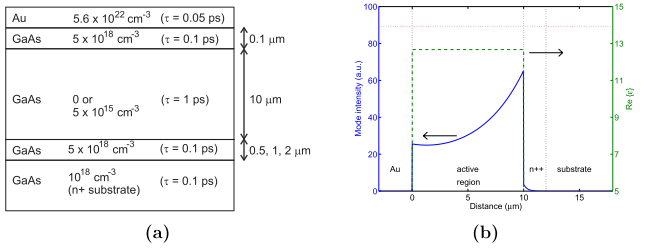
- Metal-metal waveguide  
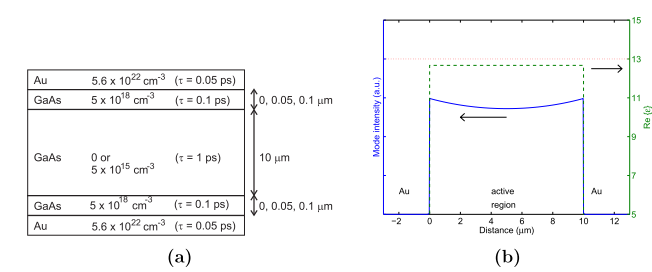
- The height is in the x axis and length is in the z axis.  

#### using the continuous source and drude model

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import GaAs_5e15_fun,GaAs_5e18_fun,Au_fun,GaAs_1e18_fun,GaAs_0_fun
import math,os


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 0.2
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 50

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
fwidth = 0.002

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global y0
    center_y = y0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(mp.inf,thickness,mp.inf),
                             center=mp.Vector3(0,center_y, 0),
                             material=material))
    y0 += thickness

def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()

# Construct layers
geometry = []

# switch to Plasmon structure
# material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
# x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
# add_layer(substrate_GaAs_thickness, GaAs_1e18_fun)
# add_layer(2,                        GaAs_5e18_fun)

# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
y0 = -0.5 * material_height
add_layer(Au_thickness,             Au_fun)
add_layer(nSI_GaAs_thickness,       GaAs_5e18_fun)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_1e18_fun)
add_layer(nSI_GaAs_thickness,       GaAs_5e18_fun)
add_layer(Au_thickness,             Au_fun)

###-------------------------source---------------------------###
resolution = 50
sx = 15
sy = material_height
sz = 0
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    src=mp.GaussianSource(frequency=freq_in_meep,fwidth=fwidth),
                    component=mp.Hz,
                    center=mp.Vector3(-sx/2,0,0),
                    size=mp.Vector3(0,sy,0)),
                    ]


###----------------------simulation setup------------------###
# basic setup
dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    boundary_layers=[mp.PML(dpml, direction=mp.X),
                     mp.PML(dpml, direction=mp.Y)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()

dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Hz],                # TM: Hz 非零；TE 则用 Ez
                                freq_in_meep, 0, 1,
                                where=mp.Volume(center=mp.Vector3(0, 0, 0),
                                                size=mp.Vector3(sx, sy, 0))  # ← x–y 平面
)
sigma_t = 1.0 / (2.0 * math.pi * 0.2)
t_end   = 6.0 * sigma_t + 400.0
sim.run(until=t_end)



#### Original from myself

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs

###-------------------------Material config--------------------------------------###
def drude_medium(N_cm3, tau_ps, m_eff_ratio, eps_inf)-> mp.Medium:
    # Constants
    e       = 1.602e-19
    eps0    = 8.854e-12
    m_e     = 9.109e-31
    m_eff   = m_eff_ratio * m_e
    c       = 299_792_458.0 * 1e6  # Speed of light in um/s
    N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    omega_p = math.sqrt(N_m3 * e * e / (eps0 * m_eff))  # [rad/s]
    gamma_s = 1.0 / (tau_ps * 1e-12)                     # [1/s]
    omega_meep    = omega_p / (2 * math.pi * c)           # Meep units [1/µm]
    gamma_meep   = gamma_s / (2 * math.pi * c)           # Meep units [1/µm]

    # # Convert units
    # N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    # tau     = tau_ps * 1e-12  # from ps to s

    # # Plasma frequency: ω_p^2 = Ne^2 / (eps0 * m*)
    # omega_p2_SI = N_m3 * e ** 2 / (eps0 * m_eff)  # in rad^2/s^2
    # gamma_SI    = 1 / tau  # in Hz

    # # Convert to Meep units (divide by unit_freq)
    # omega_p2_meep   = omega_p2_SI / (unit_freq ** 2)
    # gamma_meep      = gamma_SI / unit_freq

    # Return Meep medium object
    return mp.Medium(epsilon=eps_inf,E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_meep, 
                                                                gamma=gamma_meep, 
                                   )])

Au_fun         = drude_medium(N_cm3=5.6e22, tau_ps=0.05,    m_eff_ratio=0.067, eps_inf=1.0 )
GaAs_5e18_fun  = drude_medium(N_cm3=5.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_5e15_fun  = drude_medium(N_cm3=5.0e15, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_3e18_fun  = drude_medium(N_cm3=3.0e18, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_1e18_fun  = drude_medium(N_cm3=1.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_0_fun     = drude_medium(N_cm3=0,      tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)

# Perfectly Matched Layer if THz , set PML to 1
pml_layers                  = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness                = 0.2
nSI_GaAs_thickness          = 0.1
Active_GaAs_thickness       = 10
substrate_GaAs_thickness    = 50
model                       = 'MM'          # 'plasmon' or 'MM'

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
# Set up for source frequency 
c_um_s                      = 299_792_458.0 * 1e6  # 光速, µm/s
f_Hz                        = 5e12                   # 5 THz
freq_in_meep                = f_Hz / c_um_s          # ≈ 0.016678  (1/µm)，Meep 里的频率
fwidth = 0.002

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []
if model == 'plasmon':
    "switch to Plasmon structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
    x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
    add_layer(substrate_GaAs_thickness, GaAs_1e18_fun)
    add_layer(2,                        GaAs_5e18_fun)
elif model == 'MM':
    "switch to Metal-metal structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
    x0 = -0.5 * material_height
    add_layer(Au_thickness,             Au_fun)
    add_layer(nSI_GaAs_thickness,       GaAs_3e18_fun)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_5e15_fun)
add_layer(nSI_GaAs_thickness,       GaAs_3e18_fun)
add_layer(Au_thickness,             Au_fun)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    src=mp.ContinuousSource(frequency=freq_in_meep,fwidth=fwidth),
                    # src=mp.GaussianSource(frequency=freq_in_meep,fwidth=fwidth),
                    amplitude=1,
                    component=mp.Hy,
                    center=mp.Vector3(0,0,-sz/2),      # 放在结构左侧一些
                    size=mp.Vector3(sx, 0, 0)),
                    ]


###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()


dpml = 1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
                    #  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)


# sim.run(until=10)
# plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)
dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez],
                                 freq_in_meep, 0, 1,
                                 where=mp.Volume(center=mp.Vector3(0,0,0),
                                                 size=mp.Vector3(sx,0,sz))) 

# sim.plot2D(eps_parameters={'colorbar':True},  # 显示介电常数的 colorbar},
#            colorbar_parameters={
#                "label": "Ez field",           # 设置colorbar标题
#                "orientation": "vertical",     # 垂直显示
#                "position": "right",           # 放在图的右侧
#                "size": "5%",                  # colorbar的宽度
#                "pad": "2%",                   # colorbar和图之间的距离
#                "format": "{x:.2e}"            # 科学计数法显示刻度
#            },
#            labels=True)

import os

def extract_line_intensity(sim, dft_handle, component, freq_index=0, z_pos='mid'):
    """从 DFT 场里取出某个分量在 z=指定切片处沿 x 的强度 |E|^2"""
    arr = sim.get_dft_array(dft_handle, component, freq_index)  # shape ~ (Nx, Nz) 在2D
    arr = np.squeeze(arr)
    if arr.ndim == 1:
        line = arr
    else:
        if z_pos == 'mid':
            zi = arr.shape[1] // 2
        elif isinstance(z_pos, int):
            zi = max(0, min(arr.shape[1]-1, z_pos))
        else:
            zi = arr.shape[1] // 2
        line = arr[:, zi]
    I = np.abs(line)**2
    return I

def plot_line_with_eps(x_coords, I, eps_vals, title, ylabel, save_path=None):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Distance (µm) along x')
    ax1.set_ylabel(ylabel)
    ax1.plot(x_coords, I, lw=2)
    ax1.set_xlim(x_coords[0], x_coords[-1])
    ax1.set_ylim(0, np.max(I)*1.2 if np.max(I) > 0 else 1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Re{ε}')
    ax2.plot(x_coords, eps_vals, ls='--')
    ax2.set_ylim(0, max(15, np.max(eps_vals)*1.1))

    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
    plt.show()

# =======================  从 DFT 开始：前/后向分解  ==========================
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) 定义 DFT 区域（避开 PML），以及可选的 flux 面
#    请确保你在更上方定义了：material_height, sz, dpml, resolution 等变量
dft_margin_x = 0.0
dft_margin_z = dpml + 0.3      # 与 PML 保持距离，避免采样到吸收层
dft_size     = mp.Vector3(material_height - 2*dft_margin_x, 0, sz - 2*dft_margin_z)
dft_center   = mp.Vector3(0, 0, 0)

dft_fields = sim.add_dft_fields(
    [mp.Ex, mp.Ey, mp.Ez],           # 你也可以只放 Ez
    freq_in_meep,                    # 单频
    0, 1,                            # 只有一个频点
    where=mp.Volume(center=dft_center, size=dft_size)
)

# （可选）Flux 监视：下方“入射/反射面”、上方“透射面”
# 位置避开 PML 并远离近场耦合区
flux_pad = 0.5
z_ref = -0.5*sz + dpml + flux_pad        # 反射面（靠近源的一侧）
z_trn =  0.5*sz - dpml - flux_pad        # 透射面（远离源的一侧）
flux_w  = material_height - 2*0.2        # 面宽度略小于材料宽度
ref_region = mp.FluxRegion(center=mp.Vector3(0,0,z_ref), size=mp.Vector3(flux_w,0,0))
trn_region = mp.FluxRegion(center=mp.Vector3(0,0,z_trn), size=mp.Vector3(flux_w,0,0))
refl = sim.add_flux(freq_in_meep, 0, 1, ref_region)
tran = sim.add_flux(freq_in_meep, 0, 1, trn_region)

# 2) 跑到稳态（或足够长时间）
sigma_t = 1.0 / (2.0 * math.pi * fwidth)
t_end   = 6.0 * sigma_t + 600.0
sim.run(until=t_end)

# 3) 读取 DFT 数组：得到 x–z 平面上的复数场（此处以 Ez 为主）
# ---------- 安全读取 Ez 并保证得到 (Nx, Nz) ----------
def get_Ez_2d(sim, dft_handle, freq_index=0):
    arr = np.asarray(sim.get_dft_array(dft_handle, mp.Ez, freq_index))
    if arr.ndim == 2:
        # 正常 2D: (Nx, Nz)
        return arr
    elif arr.ndim == 3:
        # 可能是 (Nx, Ny, Nz)；取中间 y 切片
        Ny = arr.shape[1]
        return arr[:, Ny//2, :]
    elif arr.ndim == 1:
        # 只有一条线：强制当成 (Nx, 1)
        return arr[:, np.newaxis]
    else:
        raise RuntimeError(f"Unexpected DFT array ndim={arr.ndim}, shape={arr.shape}")

Ez_2d = get_Ez_2d(sim, dft_fields, 0)   # -> (Nx, Nz)
Nx, Nz = Ez_2d.shape


# 4) 选择一条固定 x 的“纵向 z 线”来做前/后向分解（也可对若干列做平均以降噪）
#    这里用中心 x，一般足够代表性；你也可以对 x_mid-2:x_mid+2 做平均。
x_mid = Nx // 2
Ez_z = Ez_2d[x_mid, :].astype(np.complex128)   # 复数场，沿 z

# 5) 对 z 方向做 1D FFT，按 +kz / -kz 分离前后向分量
#    使用 Hann 窗减少旁瓣；空间采样间隔近似为 Δz = 1/resolution（单位：µm/像素）
window = np.hanning(Nz)
Ez_z_win = Ez_z * window

F = np.fft.fftshift(np.fft.fft(Ez_z_win))
k = np.fft.fftshift(np.fft.fftfreq(Nz, d=1.0/resolution))  # 近似空间频率（像素单位缩放）

# 分成 +kz（前向）和 -kz（后向）
F_fwd = np.where(k > 0, F, 0)
F_bwd = np.where(k < 0, F, 0)

# 谱功率（与能量成比例，足够用于相对比较）
P_fwd_spec = float(np.sum(np.abs(F_fwd)**2))
P_bwd_spec = float(np.sum(np.abs(F_bwd)**2))

# 6) 反变换得到近似的前/后向“时域（空间域）”场分量
Ez_fwd_z = np.fft.ifft(np.fft.ifftshift(F_fwd))
Ez_bwd_z = np.fft.ifft(np.fft.ifftshift(F_bwd))

I_fwd_z = np.abs(Ez_fwd_z)**2
I_bwd_z = np.abs(Ez_bwd_z)**2
I_tot_z = np.abs(Ez_z)**2

# 7) 基于 flux monitor 的功率（更物理）
T_flux = mp.get_fluxes(tran)[0]   # 透射功率（绝对值单位取决于源幅与归一化）
R_flux = mp.get_fluxes(refl)[0]   # 反射功率
# 也可做入射功率归一化（需要先在无结构情形下记录 incident_flux）

print("\n=== 前/后向分解结果（谱域）===")
print(f"Forward (+kz) spectral power: {P_fwd_spec:.3e}")
print(f"Backward(-kz) spectral power: {P_bwd_spec:.3e}")
ratio = P_bwd_spec/(P_fwd_spec+1e-30)
print(f"Backward/Total ratio (spec):  {ratio:.3%}")

print("\n=== Flux（Poynting）结果（绝对值，未归一化）===")
print(f"Transmission flux: {T_flux:.6e}")
print(f"Reflection  flux: {R_flux:.6e}")

# 8) 画图并保存
os.makedirs("results", exist_ok=True)

# 8.1 沿 z 的前/后向强度剖面
z_coords = np.linspace(-0.5*(sz - 2*dft_margin_z), 0.5*(sz - 2*dft_margin_z), Nz)

plt.figure()
plt.plot(z_coords, I_tot_z,  lw=2, label='|Ez|² total')
plt.plot(z_coords, I_fwd_z,  lw=1.5, label='forward |Ez|² (+kz)')
plt.plot(z_coords, I_bwd_z,  lw=1.5, label='backward |Ez|² (-kz)')
plt.xlabel('z (µm)')
plt.ylabel('intensity (a.u.)')
plt.title('Forward/Backward intensity vs z (at x ~ center)')
plt.legend()
plt.tight_layout()
plt.savefig('results/FB_intensity_line_z.png', dpi=300)
plt.show()

# 8.2 整个 x–z 的 2D 强度图（总场 + 仅前向 + 仅后向）
# 前/后向 2D 重建：对每个 x 列都做同样的谱域掩膜反变换
def split_forward_backward_2d(E2d):
    Nx, Nz = E2d.shape
    I2_tot = np.abs(E2d)**2
    I2_fwd = np.zeros_like(I2_tot)
    I2_bwd = np.zeros_like(I2_tot)
    win = np.hanning(Nz)
    K = np.fft.fftshift(np.fft.fftfreq(Nz, d=1.0/resolution))
    pos = (K > 0)
    neg = (K < 0)
    for ix in range(Nx):
        col = E2d[ix, :].astype(np.complex128) * win
        F   = np.fft.fftshift(np.fft.fft(col))
        Ff  = np.where(pos, F, 0)
        Fb  = np.where(neg, F, 0)
        ef  = np.fft.ifft(np.fft.ifftshift(Ff))
        eb  = np.fft.ifft(np.fft.ifftshift(Fb))
        I2_fwd[ix, :] = np.abs(ef)**2
        I2_bwd[ix, :] = np.abs(eb)**2
    return I2_tot, I2_fwd, I2_bwd

I2_tot, I2_fwd, I2_bwd = split_forward_backward_2d(Ez_2d)

def imsave_I2(I2, title, path):
    plt.figure()
    plt.imshow(I2.T, origin='lower', aspect='auto')  # x 为横轴索引，z 为纵轴索引
    plt.xlabel('x index'); plt.ylabel('z index')
    plt.title(title)
    plt.colorbar(label='intensity (a.u.)')
    plt.tight_layout()
    plt.savefig(path, dpi=300); plt.show()

imsave_I2(I2_tot, 'Total |Ez|² (x–z)',   'results/I2_total.png')
imsave_I2(I2_fwd, 'Forward |Ez|² (+kz)', 'results/I2_forward.png')
imsave_I2(I2_bwd, 'Backward |Ez|² (-kz)','results/I2_backward.png')


# sigma_t = 1.0 / (2.0 * math.pi * fwidth)
# t_end   = 6.0 * sigma_t + 600.0
# sim.run(until=t_end)
# # ---------- 取 DFT 场并画沿 x ----------
# Ez = sim.get_dft_array(dft_fields, mp.Ez, 0)
# Ex = sim.get_dft_array(dft_fields, mp.Ex, 0)
# Ey = sim.get_dft_array(dft_fields, mp.Ey, 0)
# Ez = np.squeeze(Ez)               # (Nx, Ny, Nz) -> (Nx,)
# # Ex = np.squeeze(Ex)
# I = np.abs(Ez)**2
# # I = np.abs(Ex)**2
# plt.figure()
# x_coords = np.linspace(-cell.x/2, cell.x/2, I.shape[0])

# fig, ax1 = plt.subplots()
# color = 'tab:blue'
# ax1.set_xlabel('Distance (um) along y')
# ax1.set_ylabel('Mode Intensity |Ez|', color=color)
# ax1.plot(x_coords, I, lw=2, label='forward-projected |Ez|² (x–z, normalized)')
# ax1.tick_params(axis='x', labelcolor=color)
# ax1.set_xlim(-sx/2-1,sx/2+1)
# ax1.set_ylim(0, np.max(I)*1.2)

# eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x_coords])
# ax2 = ax1.twinx()
# color = 'tab:green'
# ax2.set_ylabel('Re{ε}', color=color)
# ax2.plot(x_coords, eps_data, color=color, linestyle='--')
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(5, 15)

# plt.title(f"Mode intensity at f={freq_in_meep:.5f} (Meep units)")
# plt.show()

# plt.savefig('results/mode_profile_forward_xy.png', dpi=300)

#### 0820

     block, center = (-5.2,0,0)
          size (0.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.9,12.9,12.9)
     block, center = (0,0,0)
          size (10,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.9,12.9,12.9)
     block, center = (5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.9,12.9,12.9)
     block, center = (5.2,0,0)
          size (0.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
-----------
Initializing structure...
time for choose_chunkdivision = 1.69277e-05 s
Working in 2D dimensions.
Computational cell is 10.6 x 0.02 x 0 with resolutio

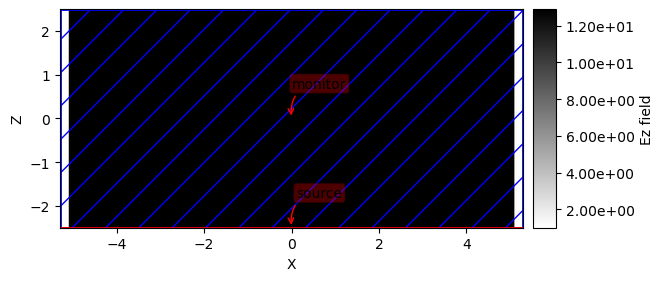

<Figure size 640x480 with 0 Axes>

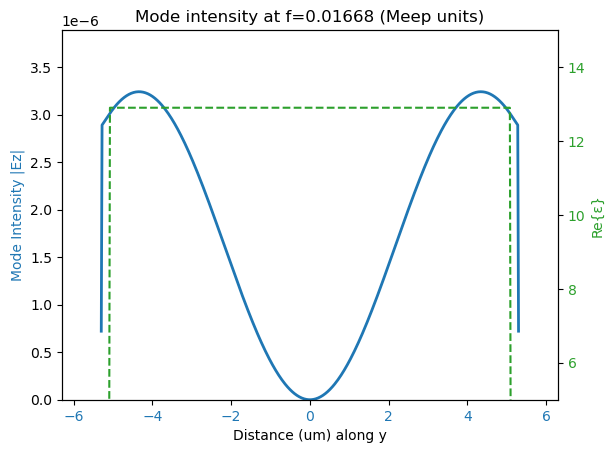

<Figure size 640x480 with 0 Axes>

In [13]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
import math

# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 0.2
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 50
model = 'MM'  # 'plasmon' or 'MM'

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c_um_s = 299_792_458.0 * 1e6  # 光速, µm/s
f_Hz = 5e12                   # 5 THz
freq_in_meep = f_Hz / c_um_s          # ≈ 0.016678  (1/µm)，Meep 里的频率
fwidth = 0.002

###-------------------------Material config--------------------------------------###
def drude_medium(N_cm3, tau_ps, m_eff_ratio, eps_inf)-> mp.Medium:
    # Constants
    e       = 1.602e-19
    eps0    = 8.854e-12
    m_e     = 9.109e-31
    m_eff   = m_eff_ratio * m_e
    c       = 299_792_458.0 * 1e6  # Speed of light in um/s
    N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    omega_p = math.sqrt(N_m3 * e * e / (eps0 * m_eff))  # [rad/s]
    gamma_s = 1.0 / (tau_ps * 1e-12)                     # [1/s]
    omega_meep    = omega_p / (2 * math.pi * c)           # Meep units [1/µm]
    gamma_meep   = gamma_s / (2 * math.pi * c)           # Meep units [1/µm]

    # # Convert units
    # N_m3    = N_cm3 * 1e6  # from cm^-3 to m^-3
    # tau     = tau_ps * 1e-12  # from ps to s

    # # Plasma frequency: ω_p^2 = Ne^2 / (eps0 * m*)
    # omega_p2_SI = N_m3 * e ** 2 / (eps0 * m_eff)  # in rad^2/s^2
    # gamma_SI    = 1 / tau  # in Hz

    # # Convert to Meep units (divide by unit_freq)
    # omega_p2_meep   = omega_p2_SI / (unit_freq ** 2)
    # gamma_meep      = gamma_SI / unit_freq

    # Return Meep medium object
    return mp.Medium(epsilon=eps_inf,E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_meep, 
                                                                gamma=gamma_meep, 
                                   )])

Au_fun         = drude_medium(N_cm3=5.6e22, tau_ps=0.05,    m_eff_ratio=0.067, eps_inf=1.0 )
GaAs_5e18_fun  = drude_medium(N_cm3=5.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_5e15_fun  = drude_medium(N_cm3=5.0e15, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_3e18_fun  = drude_medium(N_cm3=3.0e18, tau_ps=1.0,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_1e18_fun  = drude_medium(N_cm3=1.0e18, tau_ps=0.1,     m_eff_ratio=0.067, eps_inf=12.9)
GaAs_0_fun  = drude_medium(N_cm3=0, tau_ps=1.0,  m_eff_ratio=0.067, eps_inf=12.9)

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []
if model == 'plasmon':
    "switch to Plasmon structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
    x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
    add_layer(substrate_GaAs_thickness, GaAs_1e18_fun)
    add_layer(2,                        GaAs_5e18_fun)
elif model == 'MM':
    "switch to Metal-metal structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
    x0 = -0.5 * material_height
    add_layer(Au_thickness,             Au_fun)
    add_layer(nSI_GaAs_thickness,       GaAs_3e18_fun)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_0_fun)
add_layer(nSI_GaAs_thickness,       GaAs_3e18_fun)
add_layer(Au_thickness,             Au_fun)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    # src=mp.ContinuousSource(frequency=freq_in_meep,fwidth=fwidth),
                    src=mp.GaussianSource(frequency=freq_in_meep,fwidth=fwidth),
                    amplitude=1,
                    component=mp.Hy,
                    center=mp.Vector3(0,0,-sz/2),      # 放在结构左侧一些
                    size=mp.Vector3(sx, 0, 0)),
                    ]


###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()


dpml = 1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
                    #  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)


# sim.run(until=10)
# plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)
dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez],
                                 freq_in_meep, 0, 1,
                                 where=mp.Volume(center=mp.Vector3(0,0,0),
                                                 size=mp.Vector3(sx,0,sz))) 

sim.plot2D(eps_parameters={'colorbar':True},  # 显示介电常数的 colorbar},
           colorbar_parameters={
               "label": "Ez field",           # 设置colorbar标题
               "orientation": "vertical",     # 垂直显示
               "position": "right",           # 放在图的右侧
               "size": "5%",                  # colorbar的宽度
               "pad": "2%",                   # colorbar和图之间的距离
               "format": "{x:.2e}"            # 科学计数法显示刻度
           },
           labels=True)

sigma_t = 1.0 / (2.0 * math.pi * fwidth)
t_end   = 6.0 * sigma_t + 600.0
sim.run(until=t_end)


# ---------- 取 DFT 场并画沿 x ----------
Ez = sim.get_dft_array(dft_fields, mp.Ez, 0)
Ex = sim.get_dft_array(dft_fields, mp.Ex, 0)
Ey = sim.get_dft_array(dft_fields, mp.Ey, 0)
Ez = np.squeeze(Ez)               # (Nx, Ny, Nz) -> (Nx,)
# Ex = np.squeeze(Ex)
I = np.abs(Ez)**2
# I = np.abs(Ex)**2
plt.figure()
x_coords = np.linspace(-cell.x/2, cell.x/2, I.shape[0])

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Distance (um) along y')
ax1.set_ylabel('Mode Intensity |Ez|', color=color)
ax1.plot(x_coords, I, lw=2, label='forward-projected |Ez|² (x–z, normalized)')
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_xlim(-sx/2-1,sx/2+1)
ax1.set_ylim(0, np.max(I)*1.2)

eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x_coords])
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x_coords, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title(f"Mode intensity at f={freq_in_meep:.5f} (Meep units)")
plt.show()

plt.savefig('results/mode_profile_forward_xz.png', dpi=300)

#### Change to x-y axis

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import math

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c_um_s = 299_792_458.0 * 1e6  # 光速, µm/s
f_Hz = 5e12                   # 5 THz
freq_in_meep = f_Hz / c_um_s          # ≈ 0.016678  (1/µm)，Meep 里的频率
fwidth = 0.002
model = 'plasmon'  # 'plasmon' or 'MM'

# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 0.2
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 50

###-------------------------Material config--------------------------------------###
def drude_medium(N_cm3, tau_ps, m_eff_ratio, eps_inf)-> mp.Medium:
    """refer to the official document,using the meep unit"""
    # Constants
    e = 1.602e-19
    eps0 = 8.854e-12
    m_e = 9.109e-31
    m_eff = m_eff_ratio * m_e
    a = 1e-6  # um
    c = 3e8
    unit_freq = c / a

    # Convert units
    N_m3 = N_cm3 * 1e6  # from cm^-3 to m^-3
    tau = tau_ps * 1e-12  # from ps to s

    # Plasma frequency: ω_p^2 = Ne^2 / (eps0 * m*)
    omega_p2_SI = N_m3 * e ** 2 / (eps0 * m_eff)  # in rad^2/s^2
    gamma_SI = 1 / tau  # in Hz

    # Convert to Meep units (divide by unit_freq)
    omega_p2_meep = omega_p2_SI / (unit_freq ** 2)
    gamma_meep = gamma_SI / unit_freq

    # Return Meep medium object
    return mp.Medium(epsilon=eps_inf,
                    E_susceptibilities=[mp.DrudeSusceptibility(frequency=0, 
                                                                gamma=gamma_meep, 
                                                                sigma=omega_p2_meep
                                   )])

Au_fun         = drude_medium(N_cm3=5.6e22, tau_ps=0.05,  m_eff_ratio=0.067,  eps_inf=1.0 )
GaAs_5e18_fun  = drude_medium(N_cm3=5.0e18, tau_ps=0.1,  m_eff_ratio=0.067, eps_inf=12.9)
GaAs_5e15_fun  = drude_medium(N_cm3=5.0e15, tau_ps=1.0,  m_eff_ratio=0.067, eps_inf=12.9)
GaAs_1e18_fun  = drude_medium(N_cm3=1.0e18, tau_ps=0.1,  m_eff_ratio=0.067, eps_inf=12.9)
GaAs_0_fun  = drude_medium(N_cm3=0, tau_ps=1.0,  m_eff_ratio=0.067, eps_inf=12.9)

###--------------------------geometry------------------------------------------###

def add_layer(thickness, material):
    "define the basic height of layers"
    global y0
    center_y = y0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(mp.inf,thickness,mp.inf),
                             center=mp.Vector3(0,center_y, 0),
                             material=material))
    y0 += thickness

def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()

geometry = []    

if model == 'plasmon':
    "switch to Plasmon structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
    y0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
    add_layer(substrate_GaAs_thickness, GaAs_1e18_fun)
    add_layer(2,                        GaAs_5e18_fun)
elif model == 'MM':
    "switch to Metal-metal structure"
    material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
    y0 = -0.5 * material_height
    add_layer(Au_thickness,             Au_fun)
    add_layer(nSI_GaAs_thickness,       GaAs_5e18_fun)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_1e18_fun)
add_layer(nSI_GaAs_thickness,       GaAs_5e18_fun)
add_layer(Au_thickness,             Au_fun)

###-------------------------source---------------------------###
sx = 5
sy = material_height+2
sz = 0
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(src=mp.GaussianSource(frequency=freq_in_meep,fwidth=fwidth),
                    component=mp.Hz,
                    center=mp.Vector3(-sx/2,0,0),
                    size=mp.Vector3(0,material_height-1,0))
                    ]


###----------------------simulation setup------------------###
# basic setup
dpml = 1
sim = mp.Simulation(
    cell_size=cell,
    resolution=40,
    boundary_layers=[mp.PML(dpml, mp.X),mp.PML(dpml, mp.Y)],
    geometry=geometry,
    sources=sources,
    dimensions=2,
    Courant=0.3)

dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Hz],                # TM: Hz 非零；TE 则用 Ez
                                freq_in_meep, 0, 1,
                                where=mp.Volume(center=mp.Vector3(0, 0, 0),
                                                size=mp.Vector3(sx,material_height,0))  # ← x–y 平面
                                )
sim.plot2D()

sigma_t = 1.0 / (2.0 * math.pi * fwidth)
t_end   = 6.0 * sigma_t + 400.0
sim.run(until=t_end)
# sim.run(until=10)
# plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)
# probe_pt = mp.Vector3(0.3*sx, 0, 0)
# sim.run(until=10)
# # sim.run(until_after_sources=mp.stop_when_fields_decayed(
# #     100, mp.Ez, probe_pt, 1e-8))



#### use haitao's config of plot


In [ ]:
# === pull DFT arrays ===
Ex_raw = sim.get_dft_array(dft_fields, mp.Ex, 0)
Ey_raw = sim.get_dft_array(dft_fields, mp.Ey, 0)
Hz_raw = sim.get_dft_array(dft_fields, mp.Hz, 0)

Ex = np.array(Ex_raw)
Ey = np.array(Ey_raw)
Hz = np.array(Hz_raw)

# 安全整理成二维 (Ny, Nx)；若是一维就报错（FFT 需要 Nx>=2）
def to_NyNx(a, name):
    a = np.asarray(a)
    if a.ndim == 1:
        raise ValueError(f'{name} 是 1D（形状 {a.shape}）。'
                         f'请检查 add_dft_fields 的 size=(sx, sy, 0) 且 sx、sy>0，'
                         f'分辨率也要足够，使 Nx、Ny 都 >= 2。')
    if a.ndim != 2:
        raise ValueError(f'{name} 维度异常：ndim={a.ndim}, shape={a.shape}')
    Ny, Nx = a.shape
    # 让第0维是 y（通常更长），第1维是 x；若 x 更长，就转置
    if Nx > Ny:
        a = a.T
        Ny, Nx = a.shape
    return a, Ny, Nx

Ex2d, Ny, Nx = to_NyNx(Ex, 'Ex')
Ey2d, _,  _  = to_NyNx(Ey, 'Ey')
Hz2d, _,  _  = to_NyNx(Hz, 'Hz')

if Ny < 2 or Nx < 2:
    raise ValueError(f'DFT window 太小：Ny={Ny}, Nx={Nx}。'
                     f'请增大 sx/sy 或提高 resolution，确保 (Ny,Nx)≥(2,2)。')

print(f'[DFT shapes] Ny={Ny}, Nx={Nx}')

# --- 网格坐标，与你的 DFT where 对齐 ---
x0, x1 = -0.5 * sx, 0.5 * sx
y0, y1 = -0.5 * sy, 0.5 * sy
dx = (x1 - x0) / Nx
dy = (y1 - y0) / Ny
xs = x0 + np.arange(Nx) * dx
ys = y0 + np.arange(Ny) * dy


# --- 用 Hz 在 x 上做 FFT，挑正向主 kx 表示前向传播 ---
Rows = Hz2d
win = np.kaiser(Nx, beta=10.0)
Spec = np.fft.fft(Rows * win[None, :], axis=1)
kx_all = 2 * math.pi * np.fft.fftfreq(Nx, d=dx)
P_full = np.mean(np.abs(Spec)**2, axis=0)

pos = kx_all > 0
if not np.any(pos):
    raise RuntimeError('谱里没有正 kx 分量；检查源/窗口/分辨率/材料损耗。')
idx = np.argmax(P_full[pos])
kx_sel = float(kx_all[pos][idx])

# --- 相干前向投影：把 2D → 1D（沿 y）---
phase_fwd = np.exp(-1j * kx_sel * xs) * win
norm = np.sum(win)
Ex_mode = (Ex2d @ phase_fwd) / norm     # 形状: (Ny,)
Ey_mode = (Ey2d @ phase_fwd) / norm

# --- 强度（基础版 |E|^2；如需能量密度风格，可在这乘 Re{ε(y)}）---
Iline = (np.abs(Ex_mode)**2 + np.abs(Ey_mode)**2)

# 归一化到 100%
peak = float(Iline.max()) if Iline.size else 1.0
Iline = (Iline / peak) * 100.0

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Distance (um) along y')
ax1.set_ylabel('Mode Intensity |Ex|+|Ey|', color=color)
ax1.plot(ys, Iline, lw=2, label='forward-projected |E|² (x–y, normalized)')
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_xlim(-sy/2-1,sy/2+1)
ax1.set_ylim(0, 105)

y = np.linspace(-sy/2, sy/2, 1000)
eps_data = np.array([sim.get_epsilon_point(mp.Vector3(0,yi,0)) for yi in y])
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(y, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title(f"Mode intensity at f={freq_in_meep:.5f} (Meep units)")
plt.show()
plt.savefig('results/mode_profile_forward_xy.png', dpi=300)

#### using the eigenmode source and real epsilon parameters

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import Au_XD,GaAs_Act_XD,GaAs_High_XD


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 5

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
observe_range = 0.1

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []

# switch to Plasmon structure
# material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
# x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
# add_layer(substrate_GaAs_thickness, substrate_GaAs)
# add_layer(2,                        nSI_GaAs)

# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
x0 = -0.5 * material_height
add_layer(Au_thickness,         Au_XD)
add_layer(nSI_GaAs_thickness,   GaAs_High_XD)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_Act_XD)
add_layer(nSI_GaAs_thickness,       GaAs_High_XD)
add_layer(Au_thickness,             Au_XD)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)


sources = [mp.EigenModeSource(
            src=mp.ContinuousSource(frequency=freq_in_meep),
            center=mp.Vector3(0,0,-sz/2),
            size=mp.Vector3(material_height,0,0),
            component = mp.Ex,
            # direction=mp.X,
)]
###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, np.max(eps_data)*1.2)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()

dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
    #                  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()
sim.run(until=10)
plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)


### Try the default materials (epsilon = 13) and plot the mode intensity from 3 directions

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import GaAs_active,nSI_GaAs,substrate_GaAs,material_au,material_gaas_doped,material_gaas_lightly_doped,material_gaas_substrate


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 5

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
observe_range = 0.1

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []

# switch to Plasmon structure


# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
x0 = -0.5 * material_height
add_layer(material_height,        mp.air)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    # src=mp.ContinuousSource(wavelength=wavelength),
                    src=mp.ContinuousSource(frequency=freq_in_meep),
                    amplitude=10,
                    component=mp.Hz,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(material_height,0,0)),
                    ]


###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()


dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
    #                  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()
sim.run(until=10)
plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)


### Try to check the matrix of material by meep class method

In [ ]:
import meep as mp

Au = mp.Medium(
    epsilon=1.0,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.44, gamma=0.033, sigma=1.0)])


# N = 5e18
n_GaAs = mp.Medium(
    epsilon=10.9,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.44, gamma=0.033, sigma=1.0)])

# N = 5e15 低参杂
light_GaAs = mp.Medium(
    epsilon=12.25,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.062, gamma=0.0033, sigma=1.0)])

# print(Au.epsilon(1/1.55))
print(n_GaAs.epsilon(1/103.4))

# From haitao

In [ ]:
# SI-SP (TM) @ 5 THz — forward-only kx projection of the bound mode
# Au  /  AR  /  n+  /  SI-GaAs   —   avoid MPB EigenModeSource (Drude metal not supported)

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import math, os
from QCL_materials import GaAs_5e15_fun,GaAs_5e18_fun,Au_fun,GaAs_1e18_fun,GaAs_0_fun

mp.verbosity(1)
mp.eps_averaging = True  # subpixel smoothing; suppress interface spiking

# ---------- units ----------
# speed of light in µm/s
c_um_s = 299_792_458.0 * 1e6  # [µm/s]

# ---------- Drude helpers ----------
def drude_from_carriers(n_cm3, tau_ps, m_eff):
    """Return (Meep Drude suscept., omega_p [1/s], gamma_s [1/s])."""
    e, eps0, me = 1.602176634e-19, 8.8541878128e-12, 9.10938356e-31
    n_m3  = n_cm3 * 1e6
    mstar = m_eff * me
    omega_p = math.sqrt(n_m3 * e * e / (eps0 * mstar))  # [rad/s]
    gamma_s = 1.0 / (tau_ps * 1e-12)                     # [1/s]
    freq    = omega_p / (2 * math.pi * c_um_s)           # Meep units [1/µm]
    gamma   = gamma_s / (2 * math.pi * c_um_s)           # Meep units [1/µm]
    susc = mp.DrudeSusceptibility(frequency=freq, gamma=gamma)
    return susc, omega_p, gamma_s

def eps_real_drude(eps_inf, n_cm3, tau_ps, m_eff, f_um_inv):
    """Re{eps(ω)} of Drude at target frequency (for intensity weighting)."""
    e, eps0, me = 1.602176634e-19, 8.8541878128e-12, 9.10938356e-31
    n_m3  = n_cm3 * 1e6
    mstar = m_eff * me
    wp2   = n_m3 * e * e / (eps0 * mstar)               # [rad/s]^2
    w     = 2 * math.pi * c_um_s * f_um_inv             # [rad/s]
    gamma = 1.0 / (tau_ps * 1e-12)                      # [1/s]
    eps   = eps_inf - wp2 / (w * (w + 1j * gamma))
    return float(np.real(eps))

# ---------- geometry Au / AR / n+ / SI-GaAs ----------
t_Au  = 0.10    # µm
t_AR  = 10.0
t_n   = 0.1
t_sub = 0.2

# PML & padding
dpml_x  = 3.0
dpml_y  = 30.0
pad_top = 0.2

# frequency 5 THz
f_thz  = 5.0
lam_um = (c_um_s * 1e-12) / f_thz      # λ = c/f, with f in THz
fcen   = 1.0 / lam_um                  # Meep frequency [1/µm]
fwidth = 0.003                         # narrowband

# resolution & Courant
RES, Cour = 10, 0.30

# materials (per thesis Sec.4.5)
eps_gas = 12.9
m_eff   = 0.067

AR_susc,  _, _ = drude_from_carriers(5e15, 1.0,  m_eff)
nP_susc,  _, _ = drude_from_carriers(3e18, 0.1,  m_eff)

# Gold Drude: ωp ≈ 1.37e16 rad/s, τ ≈ 0.05 ps
omega_p_Au = 1.37e16
tau_Au_ps  = 0.05
gamma_Au_s = 1.0 / (tau_Au_ps * 1e-12)
Au_freq    = omega_p_Au / (2 * math.pi * c_um_s)
Au_gamma   = gamma_Au_s / (2 * math.pi * c_um_s)
Au_susc    = mp.DrudeSusceptibility(frequency=Au_freq, gamma=Au_gamma)

AR_med  = mp.Medium(epsilon=eps_gas, E_susceptibilities=[AR_susc])
nP_med  = mp.Medium(epsilon=eps_gas, E_susceptibilities=[nP_susc])
Sub_med = mp.Medium(epsilon=eps_gas)
Au_med  = mp.Medium(epsilon=1.0,     E_susceptibilities=[Au_susc])

# cell size
H_struct = t_Au + t_AR + t_n + t_sub
H_total  = pad_top + H_struct
prop_len = 3.2 * lam_um                   # allow mode to settle
sx = prop_len + 2 * dpml_x
cell = mp.Vector3(sx, H_total + 2 * dpml_y, 0)

# stack top→bottom
geom = []
y = H_total / 2
geom.append(
    mp.Block(mp.Vector3(mp.inf, pad_top, mp.inf),
             center=mp.Vector3(0, y - pad_top/2), material=Au_fun)
)
y -= pad_top
geom.append(
    mp.Block(mp.Vector3(mp.inf, t_Au, mp.inf),
             center=mp.Vector3(0, y - t_Au/2), material=GaAs_5e18_fun)
)
y -= t_Au
geom.append(
    mp.Block(mp.Vector3(mp.inf, t_AR, mp.inf),
             center=mp.Vector3(0, y - t_AR/2), material=GaAs_1e18_fun)
)
y -= t_AR
geom.append(
    mp.Block(mp.Vector3(mp.inf, t_n, mp.inf),
             center=mp.Vector3(0, y - t_n/2), material=GaAs_5e18_fun)
)
y -= t_n
geom.append(
    mp.Block(mp.Vector3(mp.inf, t_sub, mp.inf),
             center=mp.Vector3(0, y - t_sub/2), material=Au)
)

pml_layers = [mp.PML(dpml_x, mp.X), mp.PML(dpml_y, mp.Y)]

# references
y_intf   = H_total/2 - pad_top - t_Au          # Au/AR interface (top of AR)
y_ar_top = y_intf
y_ar_bot = y_ar_top - t_AR

# ---- source TM (Hz) placed in AR center，尽量少激励辐射态 ----
src_y = 0.5 * (y_ar_top + y_ar_bot)
src_h = min(2.0, 0.4 * t_AR)                    # thin vertical line source
x_src = -0.5 * sx + dpml_x + 1.0
sources = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=fwidth),
                     component=mp.Hz, center=mp.Vector3(x_src, src_y),
                     size=mp.Vector3(0, src_h, 0))]

sim = mp.Simulation(cell_size=cell, 
                    geometry=geom, 
                    sources=sources,
                    boundary_layers=pml_layers, 
                    resolution=RES, 
                    Courant=Cour)

# ---- wide DFT monitor for good kx resolution (use center window) ----
win_w = 100.0                                  # 60–120 µm works well
x_mon = 0.0
mon_vol = mp.Volume(center=mp.Vector3(x_mon, 0, 0),
                    size=mp.Vector3(win_w, H_total, 0))
mon = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Hz], fcen, 0, 1, where=mon_vol)

# run to steady state
sigma_t = 1.0 / (2.0 * math.pi * fwidth)       # time-domain Gaussian std
t_end   = 6.0 * sigma_t + 600.0                # generous ring-down
sim.run(until=t_end)

# ---------- pull fields ----------
def as_yx(a, Ny_expect):
    # ensure array is (Ny, Nx)
    return a if abs(a.shape[0]-Ny_expect) <= abs(a.shape[1]-Ny_expect) else a.T

Ny_exp = int(round(H_total * RES))
Ex2d = as_yx(np.array(sim.get_dft_array(mon, mp.Ex, 0)), Ny_exp)
Ey2d = as_yx(np.array(sim.get_dft_array(mon, mp.Ey, 0)), Ny_exp)
Hz2d = as_yx(np.array(sim.get_dft_array(mon, mp.Hz, 0)), Ny_exp)

Ny, Nx = Ex2d.shape
y_full = np.linspace(-H_total/2, H_total/2, Ny)
depth  = y_intf - y_full  # depth measured downward from Au/AR interface

# x coords across the DFT window
x0 = x_mon - win_w/2
x1 = x_mon + win_w/2
dx = (x1 - x0) / Nx
xs = x0 + np.arange(Nx) * dx

# ---------- find +kx of bound mode using Hz spectrum ----------
k0    = 2 * math.pi / lam_um
k_sub = k0 * math.sqrt(eps_gas)

# rows within AR + n+ + small margin
mask_y = (depth >= 0.0) & (depth <= (t_AR + t_n + 2.0))
Hz_rows = Hz2d[mask_y, :]

win = np.kaiser(Nx, beta=10.0)
Spec = np.fft.fft(Hz_rows * win[None, :], axis=1)
kx_all = 2 * math.pi * np.fft.fftfreq(Nx, d=dx)  # [rad/µm]
P_full = np.mean(np.abs(Spec)**2, axis=0)

# pick strongest positive kx with kx > k_sub (guided / bound)
mask_bnd = kx_all > k_sub
if np.any(mask_bnd):
    cand_idx = np.where(mask_bnd)[0]
    idx = cand_idx[int(np.argmax(P_full[mask_bnd]))]
else:
    # fallback: strongest positive kx
    idx = int(np.argmax(P_full[kx_all > 0]))

kx_sel = float(kx_all[idx])

# ---------- forward-only coherent projection ----------
phase_fwd = np.exp(-1j * kx_sel * xs) * win
norm = np.sum(win)

Ex_mode = (Ex2d @ phase_fwd) / norm
Ey_mode = (Ey2d @ phase_fwd) / norm

# ---------- intensity with Re{eps} * |E|^2 ----------
eps_AR  = eps_real_drude(eps_gas, 5e15, 1.0,  m_eff, fcen)
eps_n   = eps_real_drude(eps_gas, 3e18, 0.1,  m_eff, fcen)
eps_sub = eps_gas

eps_line = np.empty(Ny)
for i, yy in enumerate(y_full):
    if (yy <= y_intf) and (yy > y_intf - t_AR):
        eps_line[i] = eps_AR
    elif (yy <= y_intf - t_AR) and (yy > y_intf - t_AR - t_n):
        eps_line[i] = eps_n
    else:
        eps_line[i] = eps_sub

Iline = eps_line * (np.abs(Ex_mode)**2 + np.abs(Ey_mode)**2)

# only keep below the Au/semiconductor interface
mask  = (depth >= 0) & (depth <= (t_AR + t_n + t_sub))
depth = depth[mask]
Iline = Iline[mask]

# normalize like the thesis figure; ignore first 0.5 µm under Au
norm_mask = depth >= 0.5
peak = float(np.max(Iline[norm_mask])) if np.any(norm_mask) else float(np.max(Iline))
Iline = (Iline / peak) * 100.0

# ---------- plot ----------
os.makedirs('results', exist_ok=True)
plt.figure(figsize=(7.2, 4.3))
plt.plot(depth, Iline, lw=2, label='forward-projected  εr·|E|²')
for yy in [t_AR, t_AR + t_n]:
    plt.axvline(yy, ls='--', lw=.9)
plt.xlim(0, depth.max() if depth.size else 1)
plt.ylim(0, 105)
plt.xlabel('Distance from Au/semiconductor interface  (µm)')
plt.ylabel('Mode intensity (a.u.)  ~  Re{ε(ω)}|E|²')
neff = abs(kx_sel) / k0
plt.title('SI-SP (TM)  Mode intensity at 5 THz  —  Au / AR / n⁺ / SI-GaAs')
plt.legend(title=f'n_eff ≈ {neff:.3f}', loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig('results/SISP_5THz_profile_kxproj_forward.png', dpi=300)

print(f'Selected kx = {kx_sel:.4f} rad/µm  (n_eff ≈ {neff:.4f});  k0*n_sub = {k_sub:.4f}')
print('Saved results/SISP_5THz_profile_kxproj_forward.png')
